In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/forecast-stocks-using-arima-sarima/__results__.html
/kaggle/input/forecast-stocks-using-arima-sarima/__notebook__.ipynb
/kaggle/input/forecast-stocks-using-arima-sarima/__output__.json
/kaggle/input/forecast-stocks-using-arima-sarima/custom.css
/kaggle/input/forecast-stocks-using-arima-sarima/__results___files/__results___9_0.png
/kaggle/input/forecast-stocks-using-arima-sarima/__results___files/__results___21_0.png
/kaggle/input/forecast-stocks-using-arima-sarima/__results___files/__results___16_0.png
/kaggle/input/forecast-stocks-using-arima-sarima/__results___files/__results___33_0.png
/kaggle/input/forecast-stocks-using-arima-sarima/__results___files/__results___23_0.png
/kaggle/input/forecast-stocks-using-arima-sarima/__results___files/__results___7_0.png


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller #(Augmented Dickey-Fuller test)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # autocorrelation and partial autocorrelation plots
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings("ignore")

In [10]:
data = pd.read_csv('/kaggle/input/tesla-stocks-dataset/tsla_2025.csv')

data.head(3)

,Date,Open,High,Low,Close,Volume
0,2010-06-28,1.13333,1.13333,1.13333,1.13333,0
1,2010-06-29,1.26667,1.66667,1.16933,1.59267,281749140
2,2010-06-30,1.71933,2.02800,1.55333,1.58867,257915910


In [11]:
data.describe()

,Open,High,Low,Close,Volume
count,3663.000000,3663.00000,3663.000000,3663.000000,3.663000e+03
mean,82.508332,84.36219,80.570231,82.495136,9.611352e+07
std,108.962503,111.48145,106.285465,108.907286,7.778909e+07
min,1.076000,1.10867,0.535333,1.053330,0.000000e+00
25%,12.181000,12.39630,11.873000,12.138000,4.733607e+07
50%,17.990700,18.32270,17.733300,17.980000,8.152521e+07
75%,179.500000,183.63500,175.490000,179.825000,1.216591e+08
max,475.900000,488.53990,457.510100,479.860000,9.140814e+08


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3663 entries, 0 to 3662
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3663 non-null   object 
 1   Open    3663 non-null   float64
 2   High    3663 non-null   float64
 3   Low     3663 non-null   float64
 4   Close   3663 non-null   float64
 5   Volume  3663 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 171.8+ KB


In [15]:
data['Date'] = pd.to_datetime(data['Date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3663 entries, 0 to 3662
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3663 non-null   datetime64[ns]
 1   Open    3663 non-null   float64       
 2   High    3663 non-null   float64       
 3   Low     3663 non-null   float64       
 4   Close   3663 non-null   float64       
 5   Volume  3663 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 171.8 KB


In [16]:
data.set_index('Date')

,Open,High,Low,Close,Volume
Date,,,,,
2010-06-28,1.13333,1.13333,1.13333,1.13333,0
2010-06-29,1.26667,1.66667,1.16933,1.59267,281749140
2010-06-30,1.71933,2.02800,1.55333,1.58867,257915910
2010-07-01,1.66667,1.72800,1.35133,1.46400,123447945
2010-07-02,1.53333,1.54000,1.24733,1.28000,77127105
...,...,...,...,...,...
2025-01-13,383.21000,403.79000,380.07000,403.31000,67580494
2025-01-14,414.34000,422.64000,394.54000,396.36000,84565022
2025-01-15,409.90000,429.80000,405.66100,428.22000,81375460


In [19]:
data.shape

(3663, 6)

In [20]:
data.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [23]:
close_data = data['Close']
close_data.dropna()

0         1.13333
1         1.59267
2         1.58867
3         1.46400
4         1.28000
          ...    
3658    403.31000
3659    396.36000
3660    428.22000
3661    413.82000
3662    426.50000
Name: Close, Length: 3663, dtype: float64

### Explanatory Data Analyasis

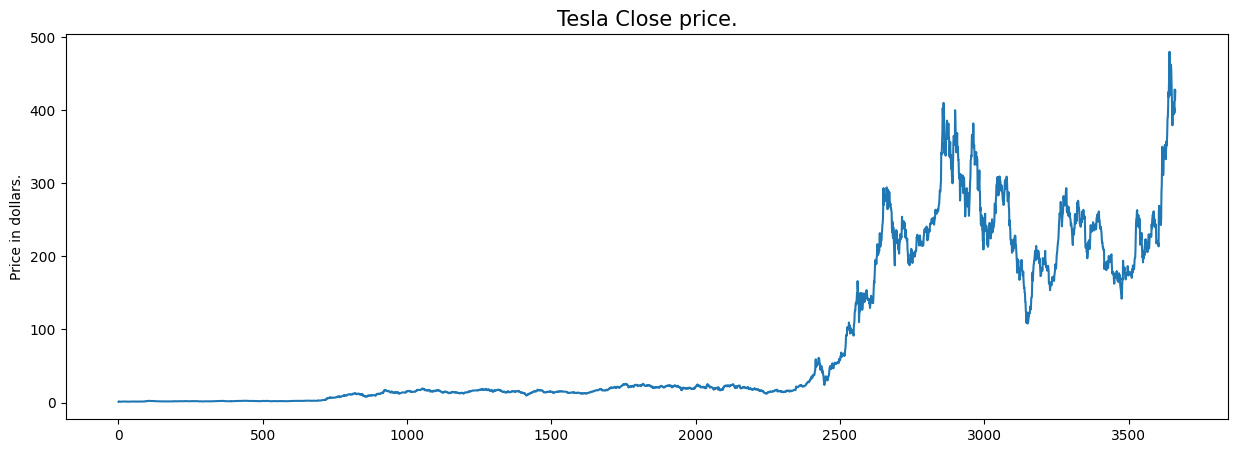

In [18]:
plt.figure(figsize=(15,5))
plt.plot(data['Close'])
plt.title('Tesla Close price.', fontsize=15)
plt.ylabel('Price in dollars.')
plt.show()

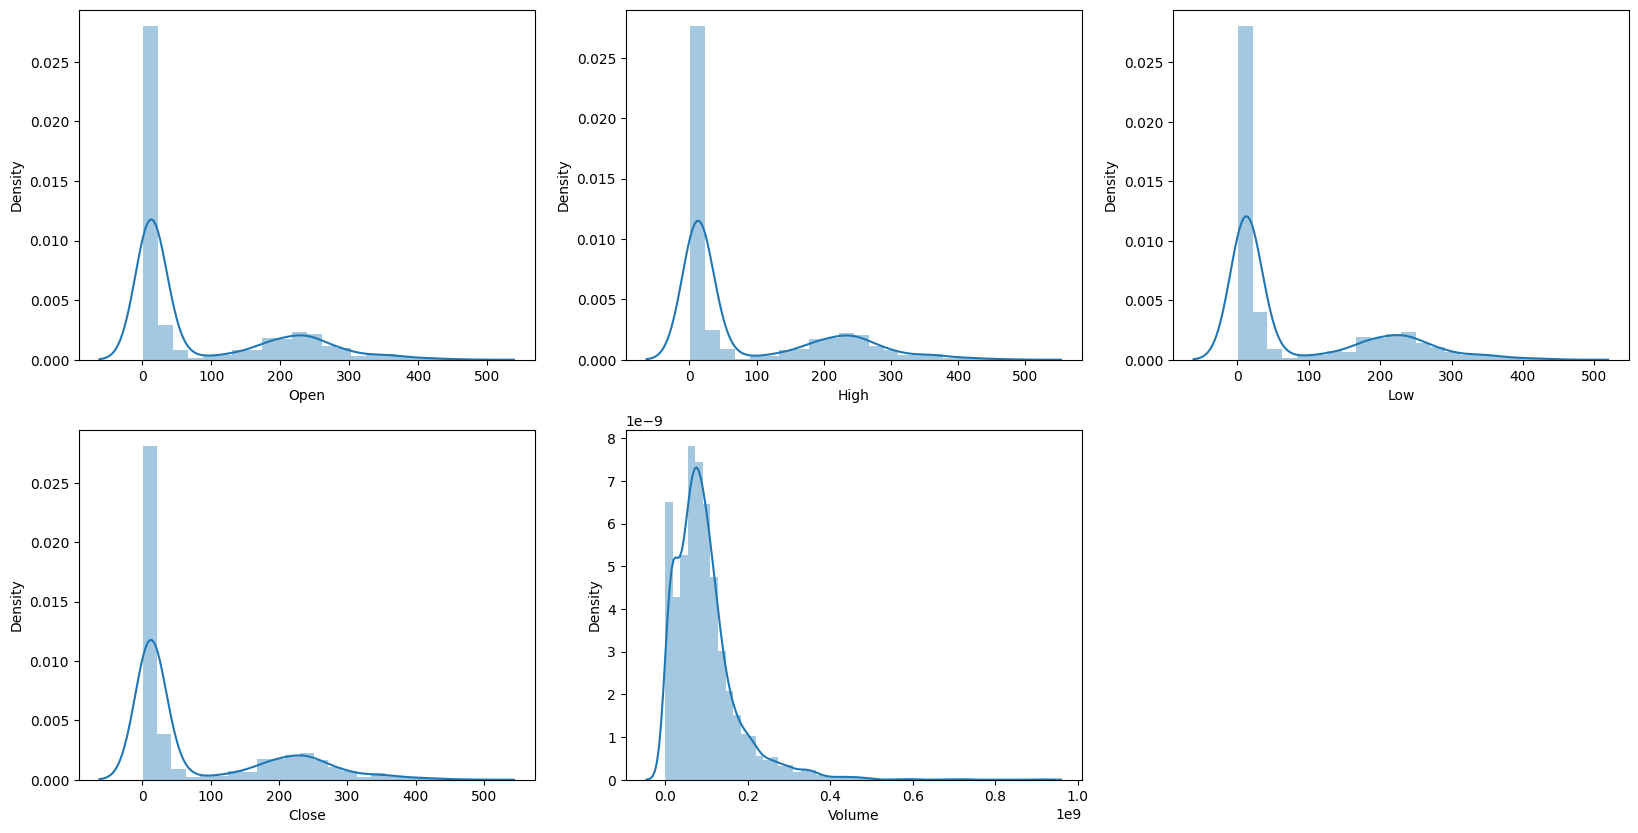

In [22]:
features = ['Open', 'High', 'Low', 'Close', 'Volume']

plt.subplots(figsize=(20,10))

for i, col in enumerate(features):
  plt.subplot(2,3,i+1)
  sns.distplot(data[col])
plt.show()

## Decompose the Time Series

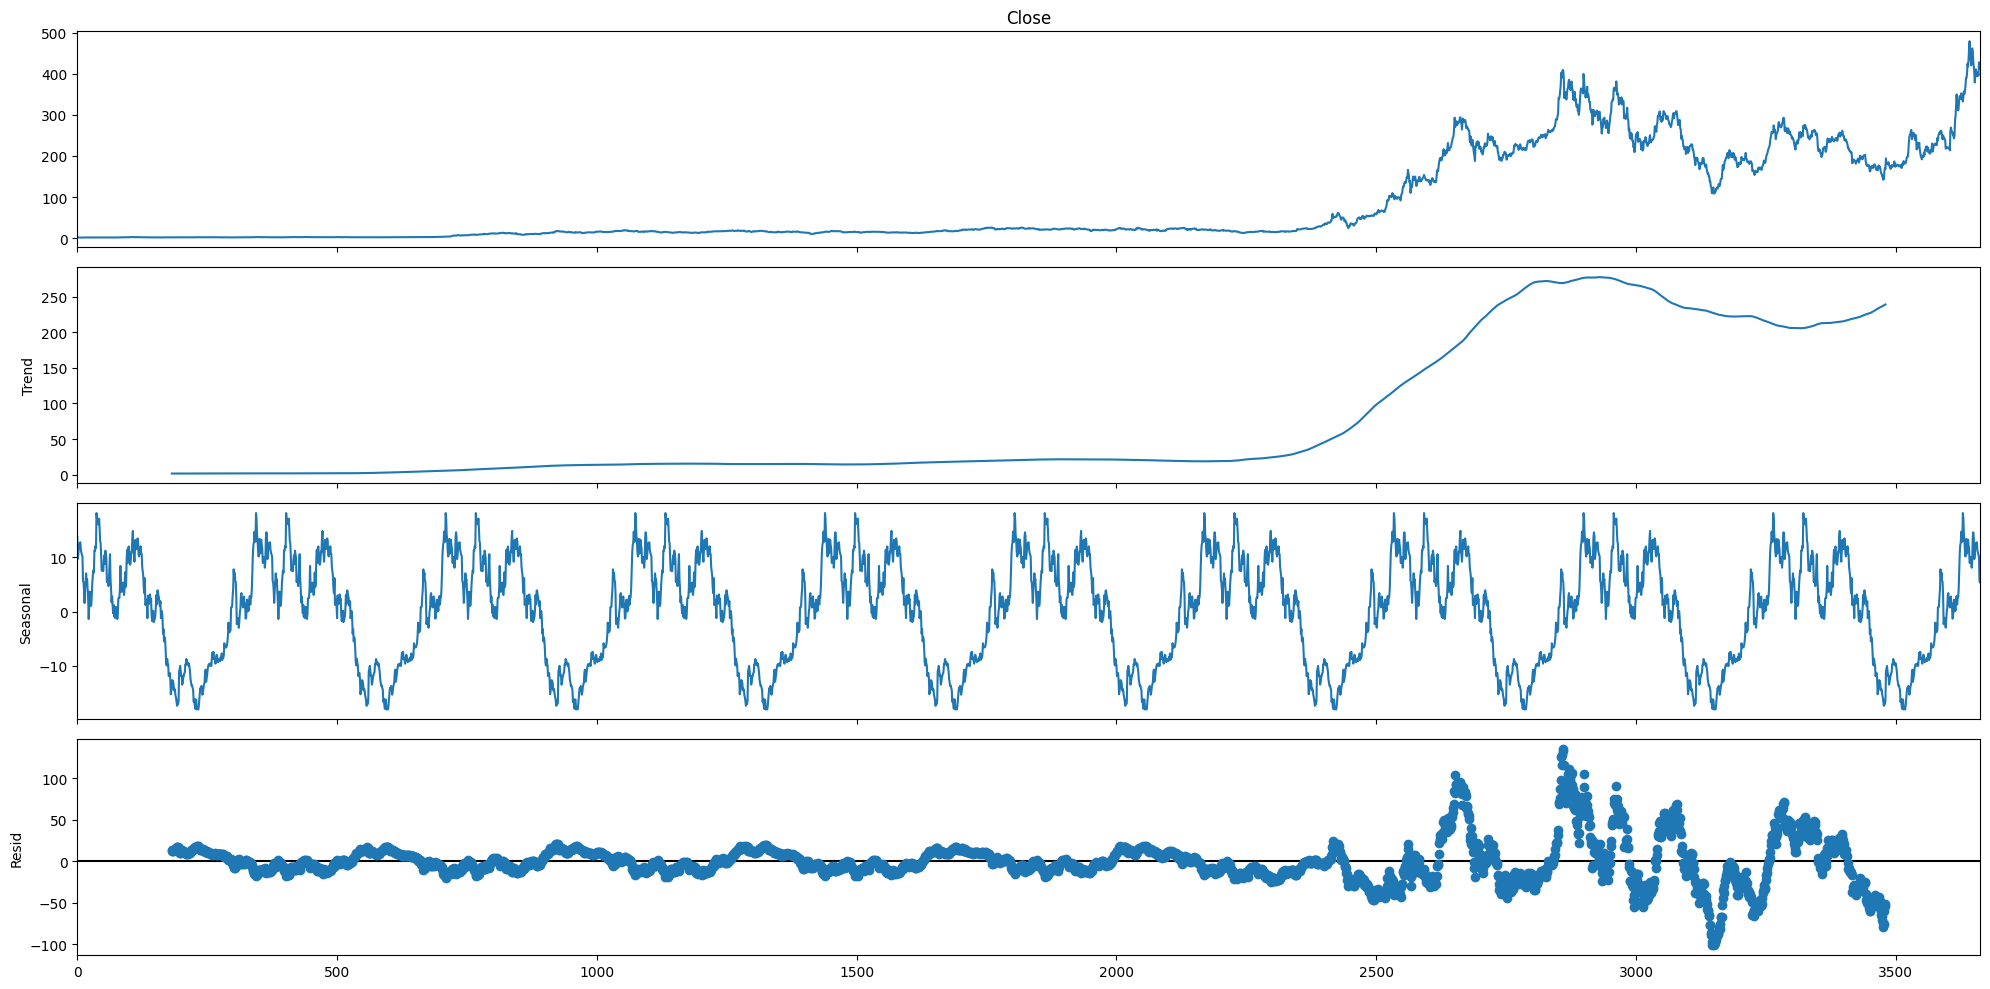

In [24]:
decomposition = seasonal_decompose(close_data, model='additive', period=365)
plt.rcParams['figure.figsize'] = (20, 10)  # Adjust width and height as desired
decomposition.plot()
plt.show()

#  Time Series Decomposition

## 1. Additive vs. Multiplicative Models

- **Additive Model:**  
  The time series is expressed as the sum of its components:  
  \[
  Y_t = Trend + Seasonality + Residual
  \]  
  Suitable when seasonal fluctuations are **constant over time**  
  (e.g., temperature changes with similar amplitude each year).

- **Multiplicative Model:**  
  The time series is expressed as:  
  \[
  Y_t = Trend \times Seasonality \times Residual
  \]  
  Suitable when seasonal variations **increase or decrease proportionally** with the level of the series  
  (e.g., sales revenue growing over years with proportionally larger seasonal spikes).

---

## 2. Period Parameter

- **`period = 365`**  
  Defines the length of the seasonal cycle.  
  - Here, it implies that the data has a **365-period seasonality** (likely **yearly seasonality in daily data**).  
  - This instructs the decomposition algorithm to look for repeating patterns every 365 observations.

---

## 3. Components of Decomposition

- **Trend:**  
  The long-term progression of the series, capturing the overall direction  
  by smoothing out short-term fluctuations.

- **Seasonality:**  
  Recurring patterns at regular intervals (daily, weekly, monthly, yearly),  
  defined by the `period` parameter.

- **Residual (Noise):**  
  The variation that remains after removing trend and seasonality,  
  representing unpredictable fluctuations.

---

 In summary, `seasonal_decompose` breaks down a time series into **Trend**, **Seasonality**, and **Residual** components using either an **Additive** or **Multiplicative** model, depending on whether seasonal effects are constant or proportional to the series level.



### Test For Stationarity


In [28]:
result = adfuller(close_data)

print("ADF Statistic", result[0])
print("Print P value", result[1])
print("Critical Values", result[4])

#interpret the results
if result[1] <= 0.05:
  print("Time Series Data is Stationary")
else:
  print("Time Series Data is Non-Stationary, Differencing is required")

ADF Statistic 0.07956265383709847
Print P value 0.9646377207173461
Critical Values {'1%': -3.432150749908472, '5%': -2.8623356709244043, '10%': -2.5671935478749135}
Time Series Data is Non-Stationary, Differencing is required


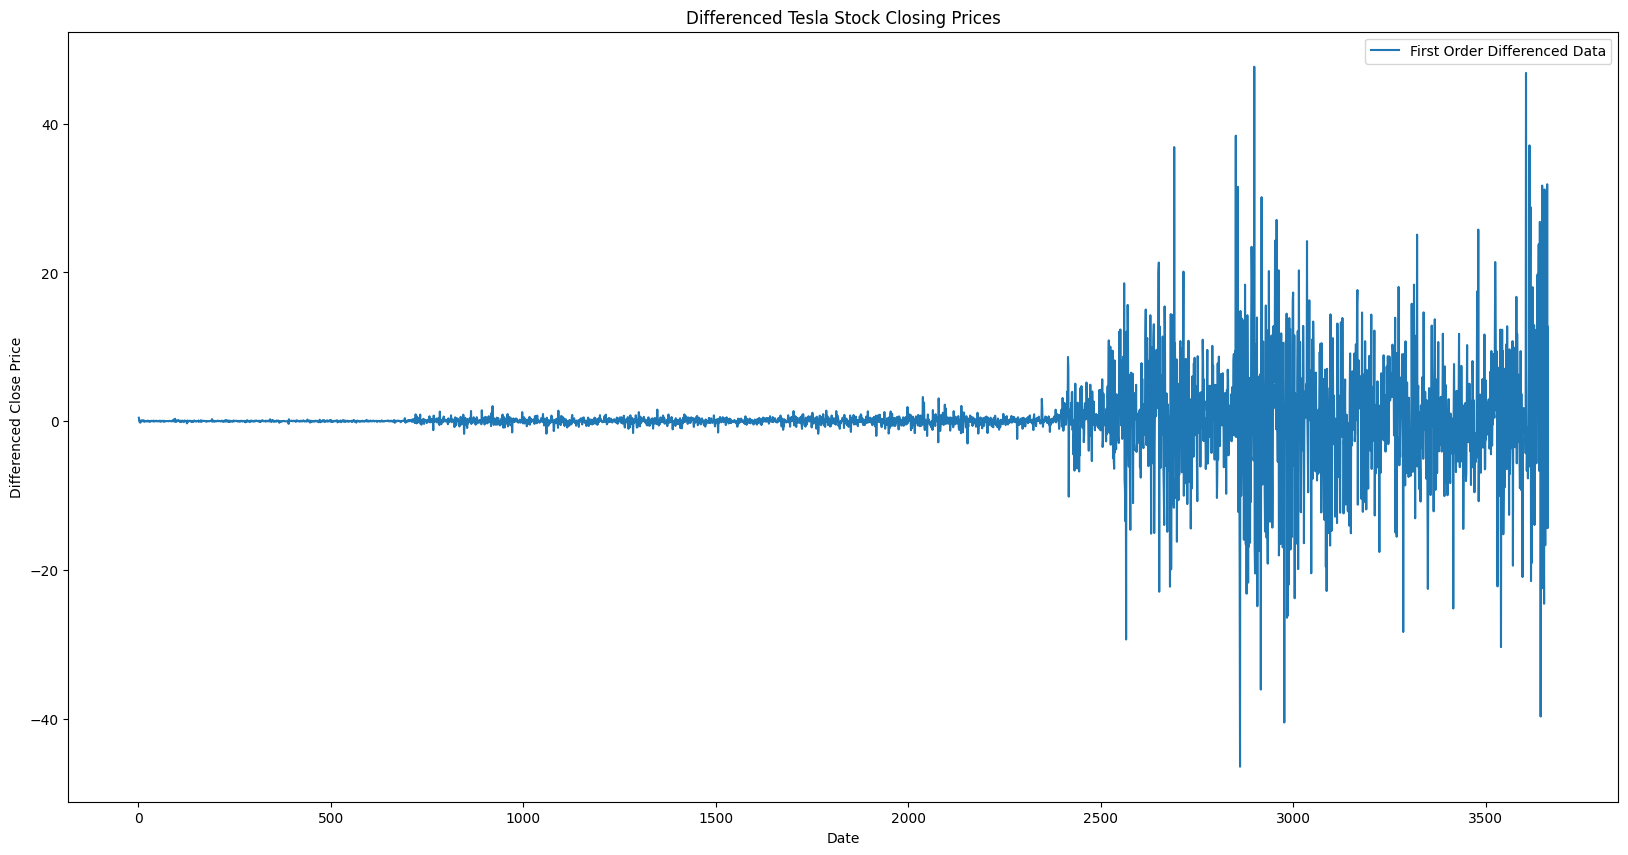

In [29]:
data_diff = close_data.diff()

#plot the differenced data
plt.plot(data_diff, label='First Order Differenced Data')
plt.title('Differenced Tesla Stock Closing Prices')
plt.xlabel('Date')
plt.ylabel('Differenced Close Price')
plt.legend()
plt.show()

Differencing is a time series preprocessing technique used to make a time series stationary.

How Much Differencing is Enough?
Start with first-order differencing (subtracting 𝑦 𝑡 − 𝑦 𝑡 − 1 y t​−y t−1​). If the series is still non-stationary, apply second-order differencing (difference the differenced series: 𝑦 𝑡 ′ − 𝑦 𝑡 − 1 ′ y t ′​−y t−1 ′​).

Avoid over-differencing, as it can lead to loss of information and increased noise.

In [30]:
#apply adfuller test to check the stationary of differenced data
diff = adfuller(data_diff.dropna())
print("ADF Statistic", diff[0])
print("Print P value", diff[1])
print("Critical Values", diff[4])

#interpret the results
if diff[1] <= 0.05:
  print("Data is Stationary.")
else:
  print("Data is Non-Stationary, Differencing is required")

ADF Statistic -10.277680116473746
Print P value 3.8522366735077876e-18
Critical Values {'1%': -3.4321522387754775, '5%': -2.862336328589075, '10%': -2.567193897993964}
Data is Stationary.


* Low p-value (≤ 0.05) and a significantly negative ADF Statistic: The time series is likely stationary.
* High p-value (> 0.05) and an ADF Statistic not much lower than Critical Values: The time series is likely non-stationary. You might need to apply differencing to make it stationary before using certain time series models.


Finally, We have Stationary dataset. Now we can move on to next step, which is ACf and PACF plots.



## ACF and PACF Plots


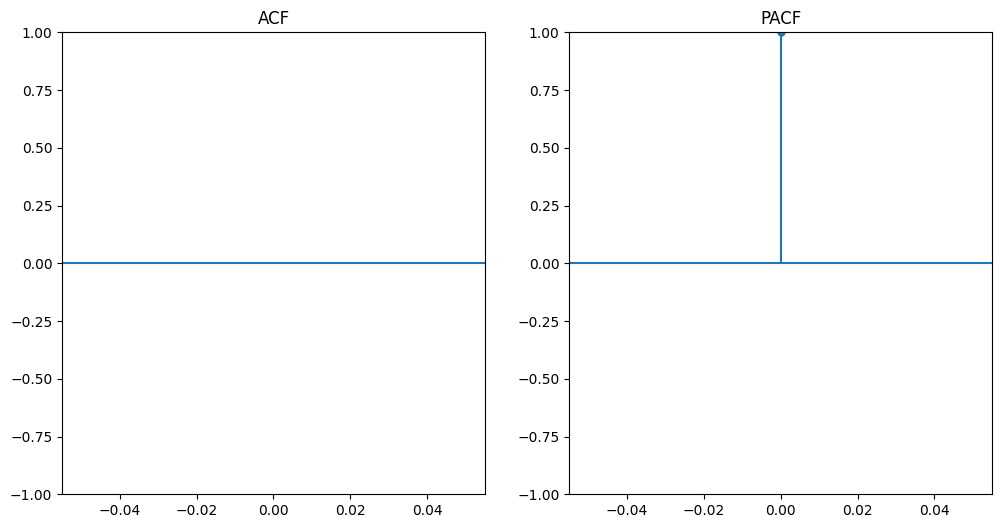

In [31]:
#plot ACF and PACF on differenced data
fig, ax = plt.subplots(1, 2, figsize=(12,6))
plot_acf(data_diff, ax=ax[0], lags=30, title='ACF')
plot_pacf(data_diff, ax=ax[1], lags=30, title='PACF')
plt.show()

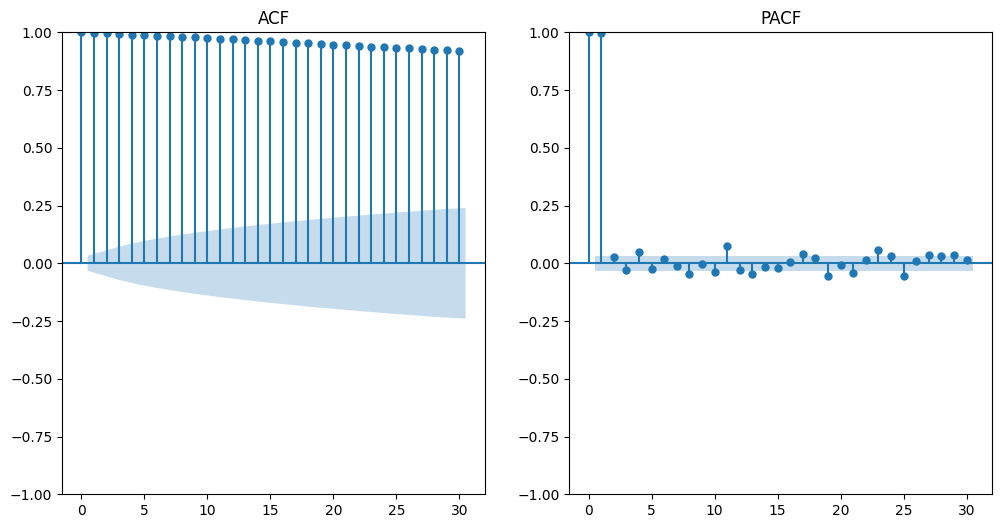

In [32]:
#plot ACF and PACF on original data
fig, ax = plt.subplots(1, 2, figsize=(12,6))
plot_acf(close_data, ax=ax[0], lags=30, title='ACF')
plot_pacf(close_data, ax=ax[1], lags=30, title='PACF')
plt.show()

## Training and Testing 

In [ ]:
train_data = close_data[:int(0.8 * len(close_data))]  # 80% for training
test_data = close_data[int(0.8 * len(close_data)):]    # 20% for testing

## Build The ARIMA Model


Understanding ARIMA Parameters


1. p (AR order): Represents the number of autoregressive terms in the model. It indicates how many past values of the time series are used to predict the current value.d
2.  (Differencing order): Represents the number of times the time series needs to be differenced to make it stationary. It addresses trends and seasonality.q
3.  (MA order): Represents the number of moving average terms in the model. It indicates how many past forecast errors are used to predict the current value1. 


In [40]:
# Build and fit the ARIMA model
model = ARIMA(train_data, order=(5, 1, 0)) #Order (p, d, q)
model_fit = model.fit()

# Make predictions on the test data
predictions = model_fit.predict(start=len(train_data), end=len(close_data)-1)

# Evaluate the model
rmse = sqrt(mean_squared_error(test_data, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 94.211


## Build The Sarima Model


In [41]:
# Fit the SARIMA model
model = SARIMAX(train_data, order=(5, 1, 0), seasonal_order=(1, 1, 1, 12)) # Example order (p, d, q) and seasonal_order (P, D, Q, s)
model_fit = model.fit()

# Make predictions on the test data
predictions = model_fit.predict(start=len(train_data), end=len(close_data)-1)

# Evaluate the model
rmse = sqrt(mean_squared_error(test_data, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 204.660


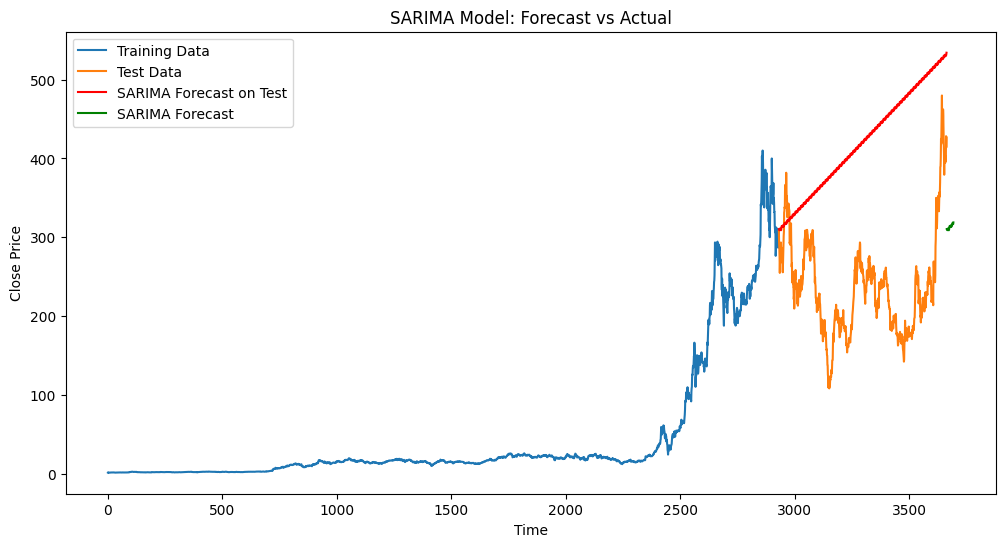

In [42]:
# Example: Forecast the next 30 days
forecast_steps = 30
sarima_forecast = model_fit.get_forecast(steps=forecast_steps).predicted_mean

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(range(len(train_data)), train_data, label='Training Data')
plt.plot(range(len(train_data), len(train_data) + len(test_data)), test_data, label='Test Data')
plt.plot(range(len(train_data), len(train_data) + len(test_data)), predictions, label='SARIMA Forecast on Test', color='red') #Plot of predictions on test data
plt.plot(range(len(train_data) + len(test_data), len(train_data) + len(test_data) + forecast_steps), sarima_forecast, label='SARIMA Forecast', color='green') #Plot of forecasted values
plt.title('SARIMA Model: Forecast vs Actual')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()